In [3]:
import numpy as np
from qiskit import QuantumCircuit
import torch
import matplotlib as plt
import pdflatex
import pylatexenc
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
#py -m pip install notebook
#.\venv\Scripts\activate

print("Test")

Test


In [29]:
num_qubits = 4

def data_to_encoding_params(input_data):
    #return (input_data / np.max(input_data)) * 2 * np.pi
    return input_data*np.pi

encoding_params = [Parameter(f'theta_{i}') for i in range(num_qubits)]
trainable_params = [Parameter(f'w_{i}') for i in range(num_qubits)]


vqc = QuantumCircuit(num_qubits)

# Encoding
for i, param in enumerate(encoding_params):
    vqc.ry(param, 4)

# Hadamard each qubit
for i in range(num_qubits):
    vqc.h(2)

# The Actual VQC
for i, param in enumerate(trainable_params):
    vqc.ry(param, 1)


# An observable for each Z-value of each qubit. Effectively telling us what the qubits expectation is in terms of  |0> and |1>
observables = [
SparsePauliOp.from_list([("ZIII", 1)]),
SparsePauliOp.from_list([("IZII", 1)]),
SparsePauliOp.from_list([("IIZI", 1)]),
SparsePauliOp.from_list([("IIIZ", 1)])
        ]

qnn = EstimatorQNN(
        circuit=vqc,
        input_params=encoding_params,
        weight_params=trainable_params,
        observables = observables
                )


input_data = np.array([1,1,1,1])  


encoded_params = data_to_encoding_params(input_data)


weights = np.array([0,0,0,0])  

# Evaluate the QNN
output = qnn.forward(encoded_params, weights)
print("QNN Output:", output)


QNN Output: [[1. 1. 1. 1.]]


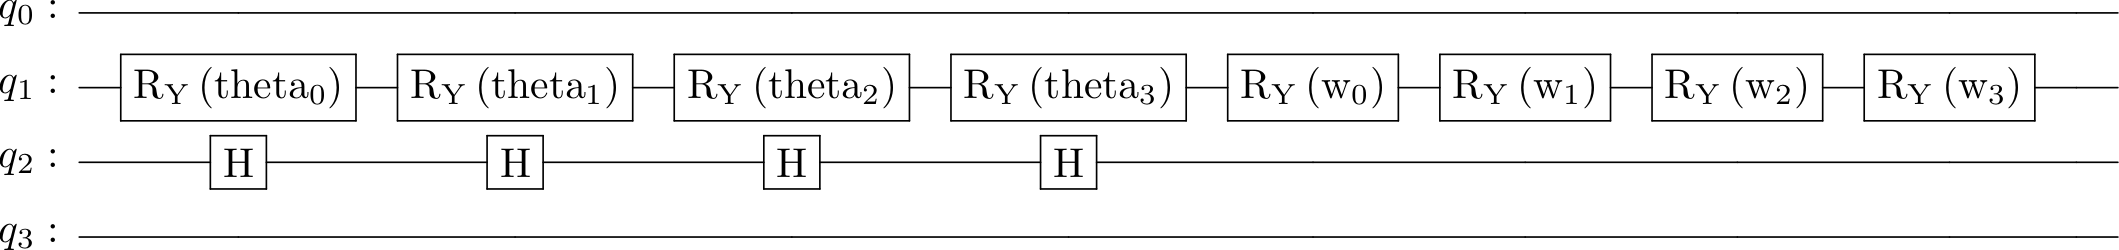

In [24]:

vqc.draw(output="latex", scale=2)